In [ ]:
import pandas as pd

from PIL import Image
import numpy as np
import os
pdf = pd.read_csv("icml_face_data.csv")
train = pd.read_csv("train.csv")
test = pdf[pdf[' Usage']=="PrivateTest"]
validation= pdf[pdf[' Usage']=="PublicTest"]

In [ ]:
print(train.shape[0])
print(test.shape[0])
print(validation.shape[0])
print(test)

28709
3589
3589
       emotion        Usage                                             pixels
32298        0  PrivateTest  170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...
32299        5  PrivateTest  7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...
32300        6  PrivateTest  232 240 241 239 237 235 246 117 24 24 22 13 12...
32301        4  PrivateTest  200 197 149 139 156 89 111 58 62 95 113 117 11...
32302        2  PrivateTest  40 28 33 56 45 33 31 78 152 194 200 186 196 20...
...        ...          ...                                                ...
35882        6  PrivateTest  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883        3  PrivateTest  178 174 172 173 181 188 191 194 196 199 200 20...
35884        0  PrivateTest  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885        3  PrivateTest  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...
35886        2  PrivateTest  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...

[3589 rows x 3 columns]


# Covert pixels to images and put into seperate emotion files for training

In [ ]:
labels=["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"]
train_folders="train"
for i,_ in enumerate(labels):
    output_folders= os.path.join(train_folders,labels[i])
    if not os.path.exists(output_folders):
        os.makedirs(output_folders)
for index, pixel_data in enumerate(train["pixels"]):
    # Convert pixels to 2D array
    pixel_values = np.array(list(map(int, pixel_data.split())))
    image_array = pixel_values.reshape(48,48)  # Reshape into a 2D array
    # Convert into images and put it into folders
    output_folders= os.path.join(train_folders,labels[train.loc[index,"emotion"]])
    img = Image.fromarray(image_array.astype('uint8'), 'L')
    image_path = os.path.join(output_folders, f'{labels[train.loc[index,"emotion"]]}_image_{index}.png')
    img.save(image_path)

#  Covert pixels to images and put into seperate emotion files for validation

In [ ]:
validation_folders="validation"
for i,_ in enumerate(labels):
    output_folders= os.path.join(validation_folders,labels[i])
    if not os.path.exists(output_folders):
        os.makedirs(output_folders)
for index, pixel_data in enumerate(validation[" pixels"]):
    index+= len(train)
    # Convert pixels to 2D array
    pixel_values = np.array(list(map(int, pixel_data.split())))
    image_array = pixel_values.reshape(48,48)  # Reshape into a 2D array
    # Convert into images and put it into folders
    output_folders= os.path.join(validation_folders,labels[validation.loc[index,"emotion"]])
    img = Image.fromarray(image_array.astype('uint8'), 'L')
    image_path = os.path.join(output_folders, f'{labels[validation.loc[index,"emotion"]]}_image_{index}.png')
    img.save(image_path)


In [ ]:
test_folders="test"
for i,_ in enumerate(labels):
    output_folders= os.path.join(test_folders,labels[i])
    if not os.path.exists(output_folders):
        os.makedirs(output_folders)
for index, pixel_data in enumerate(test[" pixels"]):
    index+= len(train) + len(test)
    # Convert pixels to 2D array
    pixel_values = np.array(list(map(int, pixel_data.split())))
    image_array = pixel_values.reshape(48,48)  # Reshape into a 2D array
    # Convert into images and put it into folders
    output_folders= os.path.join(test_folders,labels[test.loc[index,"emotion"]])
    img = Image.fromarray(image_array.astype('uint8'), 'L')
    image_path = os.path.join(output_folders, f'{labels[test.loc[index,"emotion"]]}_image_{index}.png')
    img.save(image_path)

# Delete the images (If needed)

In [ ]:
# import glob
# for label in labels:
#     folder_path = os.path.join(train_folders, label)

#     # Find all image files in the folder (you can change extensions if needed)
#     images = glob.glob(os.path.join(folder_path, "*.png"))  # For PNG images
#     # images = glob.glob(os.path.join(folder_path, "*.jpg"))  # For JPG images

#     # Delete each image file
#     for image in images:
#         os.remove(image)
#         print(f"Deleted: {image}")

# Put images into tensor to train

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Define transformations (same as your Keras input setup)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to 1 channel for grayscale images
    transforms.Resize((48, 48)),
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize([0.5], [0.5])  # Normalize with mean and std (since grayscale)
])

# Define paths for train and test datasets
train_dir = "train"
test_dir = "test"

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
validation_data = datasets.ImageFolder(root='validation', transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Define data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validation_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model class
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        # First Conv Layer (128 filters, 3x3 kernel)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.4)

        # Second Conv Layer (256 filters, 3x3 kernel)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.4)

        # Third Conv Layer (512 filters, 3x3 kernel)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.4)

        # Fourth Conv Layer (512 filters, 3x3 kernel)
        self.conv4 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout4 = nn.Dropout(0.4)

        # Fully connected layers with L2 Regularization (set with weight decay in optimizer)
        self.fc1 = nn.Linear(512 * 3 * 3, 512)  # Assuming input size is 48x48, you may need to adjust if different
        self.dropout_fc1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(512, 256)
        self.dropout_fc2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(256, 7)  # Output layer (7 classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = self.dropout3(x)

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)
        x = self.dropout4(x)

        # Flatten the tensor for the fully connected layers
        x = x.view(-1, 512 * 3 * 3)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout_fc1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout_fc2(x)
        x = self.fc3(x)  # Output layer

        return x
# Define your custom CNN (from the previous example)
model = CustomCNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, verbose=True)

# Lists to store metrics
train_losses, val_losses, train_acc, val_acc = [], [], [], []

# Training loop
num_epochs = 50

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss

        loss.backward()  # Backward pass
        optimizer.step()  # Update model weights

        # Track accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate training loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc)

    # Validation step
    model.eval()  # Set model to evaluation mode
    val_running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()

            # Track validation accuracy
            _, val_predicted = torch.max(val_outputs, 1)
            total += val_labels.size(0)
            correct += (val_predicted == val_labels).sum().item()

    # Calculate validation loss and accuracy
    val_epoch_loss = val_running_loss / len(val_loader)
    val_epoch_acc = 100 * correct / total
    val_losses.append(val_epoch_loss)
    val_acc.append(val_epoch_acc)

    # Print epoch results
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%")
    print(f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_acc:.2f}%")

    # Step the scheduler
    scheduler.step(val_epoch_loss)

Epoch [1/50], Train Loss: 1.7757, Train Accuracy: 26.59%
Validation Loss: 1.7166, Validation Accuracy: 28.64%
Epoch [2/50], Train Loss: 1.5839, Train Accuracy: 38.15%
Validation Loss: 1.4551, Validation Accuracy: 44.41%
Epoch [3/50], Train Loss: 1.4658, Train Accuracy: 43.51%
Validation Loss: 1.3960, Validation Accuracy: 45.56%
Epoch [4/50], Train Loss: 1.3841, Train Accuracy: 46.68%
Validation Loss: 1.2913, Validation Accuracy: 50.60%
Epoch [5/50], Train Loss: 1.3312, Train Accuracy: 48.98%
Validation Loss: 1.2598, Validation Accuracy: 51.32%
Epoch [6/50], Train Loss: 1.2812, Train Accuracy: 51.34%
Validation Loss: 1.2722, Validation Accuracy: 51.43%
Epoch [7/50], Train Loss: 1.2452, Train Accuracy: 52.60%
Validation Loss: 1.1816, Validation Accuracy: 54.36%
Epoch [8/50], Train Loss: 1.2186, Train Accuracy: 53.92%
Validation Loss: 1.1577, Validation Accuracy: 55.61%
Epoch [9/50], Train Loss: 1.1892, Train Accuracy: 54.57%
Validation Loss: 1.1388, Validation Accuracy: 56.87%
Epoch [10/

In [ ]:
# Validation phase (test set accuracy)
model.eval()  # Set model to evaluation mode
val_loss = 0.0
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        # Calculate test accuracy
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
val_loss /= len(test_loader)

# Print test accuracy
print(f"Test Loss: {val_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Adjust learning rate based on validation loss
scheduler.step(val_loss)

Test Loss: 0.9720, Test Accuracy: 66.01%


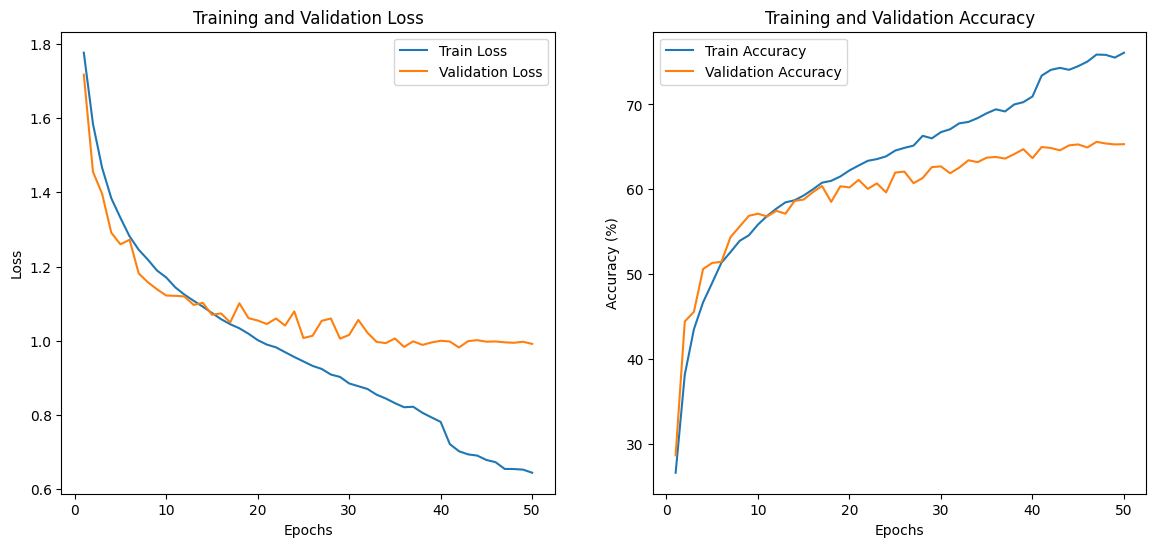

In [ ]:
import matplotlib.pyplot as plt
# Plot training & validation loss and accuracy
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(14, 6))
# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader
# from torchvision import datasets, transforms
# import os

# # Use GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Define transformations
# transform = transforms.Compose([
#     transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
#     transforms.Resize((48, 48)),  # Resize images
#     transforms.ToTensor(),  # Convert to tensor
#     transforms.Normalize([0.5], [0.5])  # Normalize grayscale
# ])

# # Load datasets
# train_dir = "train"
# test_dir = "test"
# train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
# test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# # Define data loaders
# batch_size = 64
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # Define your CustomCNN (previously provided)
# class CustomCNN(nn.Module):
#     def __init__(self):
#         super(CustomCNN, self).__init__()
#         self.conv1 = nn.Conv2d(1, 128, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(128)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.dropout = nn.Dropout(0.4)
#         self.conv2 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
#         self.bn2 = nn.BatchNorm2d(256)
#         self.conv3 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
#         self.bn3 = nn.BatchNorm2d(512)
#         self.fc1 = nn.Linear(6 * 6 * 512, 512)  # Adjust size based on the input image size
#         self.fc2 = nn.Linear(512, 256)
#         self.fc3 = nn.Linear(256, 7)  # 7 classes for output

#     def forward(self, x):
#         x = self.pool(torch.relu(self.bn1(self.conv1(x))))
#         x = self.dropout(x)
#         x = self.pool(torch.relu(self.bn2(self.conv2(x))))
#         x = self.dropout(x)
#         x = self.pool(torch.relu(self.bn3(self.conv3(x))))
#         x = self.dropout(x)
#         x = x.view(-1, 6 * 6 * 512)  # Flatten the tensor
#         x = torch.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = torch.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# # Initialize the model
# model = CustomCNN().to(device)

# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)

# # Training loop
# num_epochs = 50
# for epoch in range(num_epochs):
#     # Training phase
#     model.train()
#     running_loss = 0.0
#     correct = 0
#     total = 0
#     for inputs, labels in train_loader:
#         inputs, labels = inputs.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
#         _, predicted = torch.max(outputs, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#     train_loss = running_loss / len(train_loader)
#     train_accuracy = 100 * correct / total

#     # Evaluation phase (on test dataset)
#     model.eval()
#     test_correct = 0
#     test_total = 0
#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             _, predicted = torch.max(outputs, 1)
#             test_total += labels.size(0)
#             test_correct += (predicted == labels).sum().item()

#     test_accuracy = 100 * test_correct / test_total

#     # Print loss and accuracy for this epoch
#     print(f"Epoch [{epoch+1}/{num_epochs}], "
#           f"Train Loss: {train_loss:.4f}, "
#           f"Train Accuracy: {train_accuracy:.2f}%, "
#           f"Test Accuracy: {test_accuracy:.2f}%")
